# Runtime and Accuracy Benchmarks

This notebook explores FastMultipoleMethod performance as particle counts and solver fidelity parameters change.

## Goals

- Measure runtime scaling with particle count for a fixed solver configuration.
- Evaluate accuracy versus opening angle and multipole order using a direct-sum reference.
- Produce plots suitable for quick regressions and reports.

In [1]:
import inspect
import pathlib
import sys
from dataclasses import replace

import jax

# Force float64 in accuracy sweeps; otherwise JAX may silently downcast to float32.
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd

REPO_ROOT = pathlib.Path.cwd().resolve()
if not (REPO_ROOT / "jaccpot").exists():
    REPO_ROOT = REPO_ROOT.parent
if str(REPO_ROOT) not in sys.path:
    sys.path.append(str(REPO_ROOT))

from jaccpot import (
    FMMAdvancedConfig,
    FMMPreset,
    FarFieldConfig,
    FastMultipoleMethod,
    NearFieldConfig,
    RuntimePolicyConfig,
    TreeConfig,
)
from yggdrax import Tree, compute_tree_geometry
from yggdrax.interactions import build_interactions_and_neighbors
from examples import benchmark_utils as bench_utils

#plt.style.use("seaborn-v0_8-darkgrid")


## Benchmark configuration

Adjust the parameters below to control sweep ranges, repetition counts, and floating-point precision.

In [2]:
runtime_particle_counts = [
    512,
    1024,
    2048,
    4096,
    8192,
    16384,
    #32768,
    #65536,
    #131072,
    #262144,
    #524288,
    #1048576,
    ##2097152,
    #4194304,
    #8388608,
    #16777216
 ]
runtime_leaf_size = 16
runtime_max_order = 4
runtime_runs = 3
runtime_warmup = 1

accuracy_particle_count = 2048  # keep direct reference tractable
accuracy_leaf_size = 16
accuracy_orders = [1, 2, 3, 4]
accuracy_thetas = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9]

# New: order-only accuracy sweep at fixed θ (clean scaling curve)
order_sweep_particle_count = 1024
order_sweep_leaf_size = 16
order_sweep_orders = list(range(1, 9))
order_sweep_theta = 0.4
order_sweep_mac_type = "dehnen"

softening = 1e-3
runtime_working_dtype = jnp.float32
accuracy_working_dtype = jnp.float64  # tighten accuracy sweep floor
runtime_key = jax.random.PRNGKey(0)
accuracy_key = jax.random.PRNGKey(1)
order_diag_key = jax.random.PRNGKey(2)

runtime_advanced = FMMAdvancedConfig(
    tree=TreeConfig(leaf_target=runtime_leaf_size),
    farfield=FarFieldConfig(rotation="solidfmm", mode="auto", grouped_interactions=True),
    nearfield=NearFieldConfig(mode="bucketed", edge_chunk_size=256),
    mac_type="dehnen",
)
runtime_fmm_kwargs = dict(
    preset=FMMPreset.FAST,
    basis="solidfmm",
    theta=0.6,
    softening=softening,
    working_dtype=runtime_working_dtype,
    advanced=runtime_advanced,
)

accuracy_advanced = FMMAdvancedConfig(
    tree=TreeConfig(leaf_target=accuracy_leaf_size),
    farfield=FarFieldConfig(rotation="solidfmm", mode="pair_grouped", grouped_interactions=True),
    nearfield=NearFieldConfig(mode="bucketed", edge_chunk_size=256),
    runtime=RuntimePolicyConfig(
        max_pair_queue=65536,
        pair_process_block=512,
    ),
    mac_type="dehnen",
)
accuracy_fmm_kwargs = dict(
    preset=FMMPreset.BALANCED,
    basis="solidfmm",
    theta=0.6,
    softening=softening,
    working_dtype=accuracy_working_dtype,
    advanced=accuracy_advanced,
)


def override_fmm_kwargs(
    fmm_kwargs,
    *,
    theta=None,
    farfield_mode=None,
    grouped_interactions=None,
    nearfield_mode=None,
    nearfield_edge_chunk_size=None,
    mac_type=None,
):
    kwargs = dict(fmm_kwargs)
    advanced = kwargs["advanced"]

    farfield = advanced.farfield
    if farfield_mode is not None or grouped_interactions is not None:
        farfield = replace(
            farfield,
            mode=farfield.mode if farfield_mode is None else farfield_mode,
            grouped_interactions=(
                farfield.grouped_interactions
                if grouped_interactions is None
                else bool(grouped_interactions)
            ),
        )

    nearfield = advanced.nearfield
    if nearfield_mode is not None or nearfield_edge_chunk_size is not None:
        nearfield = replace(
            nearfield,
            mode=nearfield.mode if nearfield_mode is None else nearfield_mode,
            edge_chunk_size=(
                nearfield.edge_chunk_size
                if nearfield_edge_chunk_size is None
                else int(nearfield_edge_chunk_size)
            ),
        )

    next_mac_type = advanced.mac_type if mac_type is None else str(mac_type)
    kwargs["advanced"] = replace(
        advanced,
        farfield=farfield,
        nearfield=nearfield,
        mac_type=next_mac_type,
    )
    if theta is not None:
        kwargs["theta"] = float(theta)
    return kwargs


In [3]:
def direct_accelerations(positions, masses, *, softening, G=1.0):
    """Reference O(N^2) direct-sum accelerations."""
    positions = jnp.asarray(positions)
    masses = jnp.asarray(masses)
    diff = positions[:, None, :] - positions[None, :, :]
    dist_sq = jnp.sum(diff**2, axis=-1) + softening**2
    mask = ~jnp.eye(positions.shape[0], dtype=bool)
    inv_r3 = jnp.where(mask, 1.0 / (dist_sq * jnp.sqrt(dist_sq)), 0.0)
    weighted = diff * masses[None, :, None] * inv_r3[..., None]
    return -G * jnp.sum(weighted, axis=1)


def relative_l2_error(estimate, reference):
    estimate = jnp.asarray(estimate)
    reference = jnp.asarray(reference)
    numerator = jnp.linalg.norm(estimate - reference)
    denominator = jnp.linalg.norm(reference)
    return float(numerator / denominator)


def relative_max_error(estimate, reference):
    estimate = jnp.asarray(estimate)
    reference = jnp.asarray(reference)
    numerator = jnp.max(jnp.linalg.norm(estimate - reference, axis=-1))
    denominator = jnp.max(jnp.linalg.norm(reference, axis=-1))
    return float(numerator / denominator)


def _evaluate_prepared_kwargs(fmm):
    params = inspect.signature(fmm.evaluate_prepared_state).parameters
    if "jit_traversal" in params:
        return {"jit_traversal": True}
    return {}


def sweep_runtimes(
    particle_counts,
    *,
    leaf_size,
    max_order,
    runs,
    warmup,
    dtype,
    key,
    fmm_kwargs,
    strict=False,
 ):
    records = []
    fmm = FastMultipoleMethod(**fmm_kwargs)
    current_key = key
    for num_particles in particle_counts:
        try:
            positions, masses, current_key = bench_utils.generate_random_distribution(
                num_particles,
                key=current_key,
                dtype=dtype,
            )

            full_timing = bench_utils.time_callable(
                fmm.compute_accelerations,
                positions,
                masses,
                leaf_size=leaf_size,
                max_order=max_order,
                reuse_prepared_state=False,
                warmup=warmup,
                runs=runs,
            )

            prepare_once_timing = bench_utils.time_callable(
                fmm.prepare_state,
                positions,
                masses,
                leaf_size=leaf_size,
                max_order=max_order,
                warmup=warmup,
                runs=runs,
            )
            prepared_state = prepare_once_timing.result

            eval_kwargs = _evaluate_prepared_kwargs(fmm)
            eval_timing = bench_utils.time_callable(
                fmm.evaluate_prepared_state,
                prepared_state,
                warmup=warmup,
                runs=runs,
                **eval_kwargs,
            )

            records.append(
                {
                    "num_particles": num_particles,
                    "mean_seconds": full_timing.mean,
                    "std_seconds": full_timing.std,
                    "prepare_mean_seconds": prepare_once_timing.mean,
                    "prepare_std_seconds": prepare_once_timing.std,
                    "evaluate_mean_seconds": eval_timing.mean,
                    "evaluate_std_seconds": eval_timing.std,
                    "error": "",
                }
            )
        except Exception as exc:
            msg = f"{type(exc).__name__}: {exc}"
            print(f"[sweep_runtimes] N={num_particles} failed: {msg}")
            records.append(
                {
                    "num_particles": num_particles,
                    "mean_seconds": float("nan"),
                    "std_seconds": float("nan"),
                    "prepare_mean_seconds": float("nan"),
                    "prepare_std_seconds": float("nan"),
                    "evaluate_mean_seconds": float("nan"),
                    "evaluate_std_seconds": float("nan"),
                    "error": msg,
                }
            )
            if strict:
                raise
    return pd.DataFrame(records)


def sweep_prepared_eval_runtimes(
    particle_counts,
    *,
    leaf_size,
    max_order,
    runs,
    warmup,
    dtype,
    key,
    fmm_kwargs,
    strict=False,
 ):
    records = []
    fmm = FastMultipoleMethod(**fmm_kwargs)
    current_key = key
    for num_particles in particle_counts:
        try:
            positions, masses, current_key = bench_utils.generate_random_distribution(
                num_particles,
                key=current_key,
                dtype=dtype,
            )
            state = fmm.prepare_state(
                positions,
                masses,
                leaf_size=leaf_size,
                max_order=max_order,
            )
            eval_kwargs = _evaluate_prepared_kwargs(fmm)

            eval_timing = bench_utils.time_callable(
                fmm.evaluate_prepared_state,
                state,
                warmup=warmup,
                runs=runs,
                **eval_kwargs,
            )

            eval_jit = jax.jit(
                lambda st: fmm.evaluate_prepared_state(st, **eval_kwargs)
            )
            # Trigger compilation outside measured runs.
            bench_utils.time_callable(
                eval_jit,
                state,
                warmup=0,
                runs=1,
            )
            eval_jit_timing = bench_utils.time_callable(
                eval_jit,
                state,
                warmup=warmup,
                runs=runs,
            )

            records.append(
                {
                    "num_particles": num_particles,
                    "prepared_eval_mean_seconds": eval_timing.mean,
                    "prepared_eval_std_seconds": eval_timing.std,
                    "prepared_eval_jit_mean_seconds": eval_jit_timing.mean,
                    "prepared_eval_jit_std_seconds": eval_jit_timing.std,
                    "error": "",
                }
            )
        except Exception as exc:
            msg = f"{type(exc).__name__}: {exc}"
            print(f"[sweep_prepared_eval_runtimes] N={num_particles} failed: {msg}")
            records.append(
                {
                    "num_particles": num_particles,
                    "prepared_eval_mean_seconds": float("nan"),
                    "prepared_eval_std_seconds": float("nan"),
                    "prepared_eval_jit_mean_seconds": float("nan"),
                    "prepared_eval_jit_std_seconds": float("nan"),
                    "error": msg,
                }
            )
            if strict:
                raise
    return pd.DataFrame(records)


def profile_prepare_components(
    particle_counts,
    *,
    leaf_size,
    max_order,
    dtype,
    key,
    fmm_kwargs,
    runs,
    warmup,
    strict=False,
):
    records = []
    fmm = FastMultipoleMethod(**fmm_kwargs)
    current_key = key

    tree_type = str(getattr(fmm._impl, "tree_type", "radix"))
    tree_mode = str(getattr(fmm._impl, "tree_build_mode", "lbvh"))
    ygg_build_mode = "fixed_depth" if tree_mode == "fixed_depth" else "adaptive"
    theta_val = float(getattr(fmm._impl, "theta", fmm_kwargs.get("theta", 0.6)))
    traversal_cfg = fmm.advanced.runtime.traversal_config
    mac_type = str(getattr(fmm, "mac_type", "dehnen"))
    dehnen_radius_scale = float(getattr(fmm._impl, "dehnen_radius_scale", 1.0))

    for num_particles in particle_counts:
        try:
            positions, masses, current_key = bench_utils.generate_random_distribution(
                num_particles,
                key=current_key,
                dtype=dtype,
            )

            tree_timing = bench_utils.time_callable(
                Tree.from_particles,
                positions,
                masses,
                tree_type=tree_type,
                build_mode=ygg_build_mode,
                return_reordered=True,
                leaf_size=int(leaf_size),
                warmup=warmup,
                runs=runs,
            )

            tree = Tree.from_particles(
                positions,
                masses,
                tree_type=tree_type,
                build_mode=ygg_build_mode,
                return_reordered=True,
                leaf_size=int(leaf_size),
            )
            geometry = compute_tree_geometry(tree, tree.positions_sorted)

            interactions_timing = bench_utils.time_callable(
                build_interactions_and_neighbors,
                tree,
                geometry,
                theta=theta_val,
                traversal_config=traversal_cfg,
                mac_type=mac_type,
                dehnen_radius_scale=dehnen_radius_scale,
                warmup=warmup,
                runs=runs,
            )

            prepare_timing = bench_utils.time_callable(
                fmm.prepare_state,
                positions,
                masses,
                leaf_size=int(leaf_size),
                max_order=max_order,
                warmup=warmup,
                runs=runs,
            )

            residual = max(
                float(prepare_timing.mean)
                - float(tree_timing.mean)
                - float(interactions_timing.mean),
                0.0,
            )
            records.append(
                {
                    "num_particles": num_particles,
                    "tree_build_mean_seconds": float(tree_timing.mean),
                    "interactions_mean_seconds": float(interactions_timing.mean),
                    "upward_mean_seconds": residual,
                    "downward_mean_seconds": 0.0,
                    "prepare_component_sum_seconds": float(prepare_timing.mean),
                    "error": "",
                }
            )
        except Exception as exc:
            msg = f"{type(exc).__name__}: {exc}"
            print(f"[profile_prepare_components] N={num_particles} failed: {msg}")
            records.append(
                {
                    "num_particles": num_particles,
                    "tree_build_mean_seconds": float("nan"),
                    "upward_mean_seconds": float("nan"),
                    "interactions_mean_seconds": float("nan"),
                    "downward_mean_seconds": float("nan"),
                    "prepare_component_sum_seconds": float("nan"),
                    "error": msg,
                }
            )
            if strict:
                raise

    return pd.DataFrame(records)


def sweep_accuracy(
    positions,
    masses,
    *,
    thetas,
    orders,
    leaf_size,
    fmm_kwargs,
 ):
    reference = direct_accelerations(
        positions,
        masses,
        softening=fmm_kwargs.get("softening", 0.0),
    )
    rows = []

    # Reuse one solver per theta and evaluate through prepared-state API.
    for theta in thetas:
        theta_kwargs = dict(fmm_kwargs)
        theta_kwargs["theta"] = theta
        fmm = FastMultipoleMethod(**theta_kwargs)
        if fmm.basis != "solidfmm" or fmm.complex_rotation != "solidfmm":
            raise ValueError(
                "sweep_accuracy must use basis='solidfmm' and solidfmm rotation convention"
            )

        for order in orders:
            state = fmm.prepare_state(
                positions,
                masses,
                leaf_size=leaf_size,
                max_order=order,
            )
            accelerations = fmm.evaluate_prepared_state(state)
            rows.append(
                {
                    "theta": float(theta),
                    "max_order": int(order),
                    "relative_l2_error": relative_l2_error(accelerations, reference),
                    "relative_max_error": relative_max_error(accelerations, reference),
                }
            )

    return pd.DataFrame(rows)


## Operator accuracy diagnostics

These checks isolate accuracy scaling of individual operators (P2M/M2M/M2L/L2P) outside the full tree/MAC pipeline. They help confirm whether order improves accuracy for z-aligned and off-axis interactions.

In [4]:
from jaccpot.operators.real_harmonics import (
    evaluate_local_real,
    m2l_real,
    m2m_real,
    p2m_real_direct,
    translate_along_z_m2l_real,
    sh_size,
 )

def m2m_error_vs_order(*, orders, child_center, parent_center, positions, masses):
    errors = []
    for order in orders:
        # direct P2M about parent center
        deltas_parent = positions - parent_center
        m_parent = jnp.sum(
            jax.vmap(lambda d, m: p2m_real_direct(d, m, order=order))(deltas_parent, masses),
            axis=0,
        )
        # P2M about child + M2M to parent
        deltas_child = positions - child_center
        m_child = jnp.sum(
            jax.vmap(lambda d, m: p2m_real_direct(d, m, order=order))(deltas_child, masses),
            axis=0,
        )
        delta_m2m = child_center - parent_center
        m_trans = m2m_real(m_child, delta_m2m, order=order)
        err = float(jnp.linalg.norm(m_trans - m_parent) / jnp.linalg.norm(m_parent))
        errors.append(err)
    return errors


def m2l_error_vs_order(*, orders, source_pos, local_center, eval_offset):
    errors = []
    for order in orders:
        multipole = p2m_real_direct(source_pos, jnp.asarray(1.0), order=order)
        # M2L uses delta = target - source
        delta_m2l = local_center - jnp.asarray([0.0, 0.0, 0.0])
        local = m2l_real(multipole, delta_m2l, order=order)
        eval_point = local_center + eval_offset
        delta_l2p = local_center - eval_point
        potential_fmm = evaluate_local_real(local, delta_l2p, order=order)
        r = jnp.linalg.norm(eval_point - source_pos)
        potential_direct = 1.0 / r
        err = float(jnp.abs(potential_fmm - potential_direct) / jnp.abs(potential_direct))
        errors.append(err)
    return errors


def m2l_error_zaxis_vs_order(*, orders, source_pos, local_center, eval_offset):
    errors = []
    for order in orders:
        multipole = p2m_real_direct(source_pos, jnp.asarray(1.0), order=order)
        R = jnp.linalg.norm(local_center - jnp.asarray([0.0, 0.0, 0.0]))
        local = translate_along_z_m2l_real(multipole, jnp.asarray(R), order=order)
        eval_point = local_center + eval_offset
        delta_l2p = local_center - eval_point
        potential_fmm = evaluate_local_real(local, delta_l2p, order=order)
        r = jnp.linalg.norm(eval_point - source_pos)
        potential_direct = 1.0 / r
        err = float(jnp.abs(potential_fmm - potential_direct) / jnp.abs(potential_direct))
        errors.append(err)
    return errors

In [5]:
orders_diag = [1, 2, 3, 4, 5, 6]

# M2M check (two particles in child node)
child_center = jnp.array([0.2, -0.1, 0.3])
parent_center = jnp.array([0.0, 0.0, 0.0])
positions_m2m = jnp.array([[0.3, -0.05, 0.25], [0.1, -0.2, 0.45]])
masses_m2m = jnp.array([1.2, 0.7])
m2m_errors = m2m_error_vs_order(
    orders=orders_diag,
    child_center=child_center,
    parent_center=parent_center,
    positions=positions_m2m,
    masses=masses_m2m,
 )

# M2L on z-axis (translation-only, no rotation)
source_pos = jnp.array([0.0, 0.0, 0.0])
local_center_z = jnp.array([0.0, 0.0, 5.0])
eval_offset = jnp.array([0.2, -0.1, 0.15])
m2l_z_errors = m2l_error_zaxis_vs_order(
    orders=orders_diag,
    source_pos=source_pos,
    local_center=local_center_z,
    eval_offset=eval_offset,
 )

# M2L off-axis (full rotation path)
local_center_off = jnp.array([3.0, 2.0, 4.0])
m2l_off_errors = m2l_error_vs_order(
    orders=orders_diag,
    source_pos=source_pos,
    local_center=local_center_off,
    eval_offset=eval_offset,
 )

pd.DataFrame(
    {
        "order": orders_diag,
        "m2m_rel_err": m2m_errors,
        "m2l_zaxis_rel_err": m2l_z_errors,
        "m2l_offaxis_rel_err": m2l_off_errors,
    }
 )

,order,m2m_rel_err,m2l_zaxis_rel_err,m2l_offaxis_rel_err
0,1,0.111064,4.130415e-05,0.007265
1,2,0.117183,6.179289e-05,0.007455
2,3,0.117348,3.158242e-06,0.007470
3,4,0.117350,2.745702e-08,0.007469
4,5,0.117350,6.115932e-09,0.007469
5,6,0.117350,4.090800e-10,0.007469


## Runtime sweep

Time the end-to-end acceleration evaluation for increasing particle counts. Warmup runs amortize compilation overhead so the reported statistics focus on steady-state throughput.

In [7]:
runtime_df = sweep_runtimes(
    runtime_particle_counts,
    leaf_size=runtime_leaf_size,
    max_order=runtime_max_order,
    runs=runtime_runs,
    warmup=runtime_warmup,
    dtype=runtime_working_dtype,
    key=runtime_key,
    fmm_kwargs=runtime_fmm_kwargs,
 )
runtime_df

runtime_df_sorted = runtime_df.sort_values("num_particles")

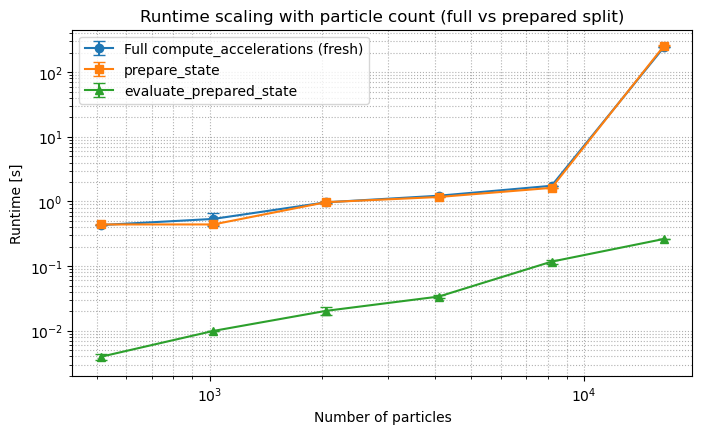

In [8]:
fig, ax = plt.subplots(figsize=(8, 4.5))

ax.errorbar(
    runtime_df_sorted["num_particles"],
    runtime_df_sorted["mean_seconds"],
    yerr=runtime_df_sorted["std_seconds"],
    fmt="o-",
    capsize=4,
    label="Full compute_accelerations (fresh)",
)
ax.errorbar(
    runtime_df_sorted["num_particles"],
    runtime_df_sorted["prepare_mean_seconds"],
    yerr=runtime_df_sorted["prepare_std_seconds"],
    fmt="s-",
    capsize=4,
    label="prepare_state",
)
ax.errorbar(
    runtime_df_sorted["num_particles"],
    runtime_df_sorted["evaluate_mean_seconds"],
    yerr=runtime_df_sorted["evaluate_std_seconds"],
    fmt="^-",
    capsize=4,
    label="evaluate_prepared_state",
)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Number of particles")
ax.set_ylabel("Runtime [s]")
ax.set_title("Runtime scaling with particle count (full vs prepared split)")
ax.grid(True, which="both", linestyle=":", linewidth=0.8)
ax.legend()
plt.show()

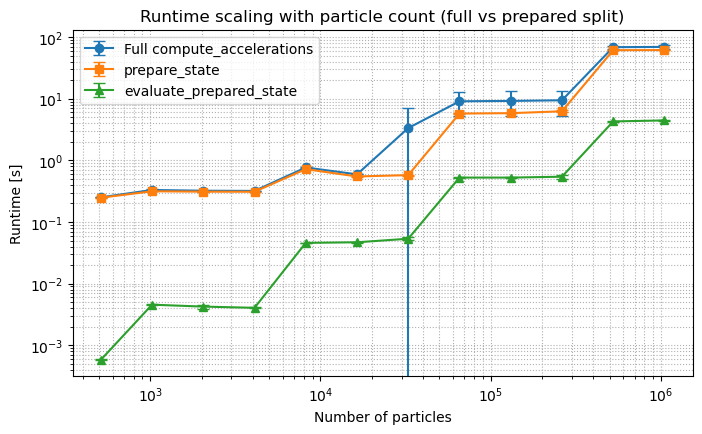

In [10]:
fig, ax = plt.subplots(figsize=(8, 4.5))

ax.errorbar(
    runtime_df_sorted["num_particles"],
    runtime_df_sorted["mean_seconds"],
    yerr=runtime_df_sorted["std_seconds"],
    fmt="o-",
    capsize=4,
    label="Full compute_accelerations (fresh)",
)
ax.errorbar(
    runtime_df_sorted["num_particles"],
    runtime_df_sorted["prepare_mean_seconds"],
    yerr=runtime_df_sorted["prepare_std_seconds"],
    fmt="s-",
    capsize=4,
    label="prepare_state",
)
ax.errorbar(
    runtime_df_sorted["num_particles"],
    runtime_df_sorted["evaluate_mean_seconds"],
    yerr=runtime_df_sorted["evaluate_std_seconds"],
    fmt="^-",
    capsize=4,
    label="evaluate_prepared_state",
)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Number of particles")
ax.set_ylabel("Runtime [s]")
ax.set_title("Runtime scaling with particle count (full vs prepared split)")
ax.grid(True, which="both", linestyle=":", linewidth=0.8)
ax.legend()
plt.show()


## Prepared-State Steady-State and Prepare Breakdown


In [5]:
runtime_prepared_df = sweep_prepared_eval_runtimes(
    runtime_particle_counts,
    leaf_size=runtime_leaf_size,
    max_order=runtime_max_order,
    runs=runtime_runs,
    warmup=runtime_warmup,
    dtype=runtime_working_dtype,
    key=runtime_key,
    fmm_kwargs=runtime_fmm_kwargs,
)
runtime_prepared_df


,num_particles,prepared_eval_mean_seconds,prepared_eval_std_seconds,prepared_eval_jit_mean_seconds,prepared_eval_jit_std_seconds,error
0,512,0.002626,0.000081,0.002367,0.000036,
1,1024,0.010416,0.000613,0.009949,0.000072,
2,2048,0.020310,0.002302,0.018314,0.000062,
3,4096,0.035974,0.004091,0.032699,0.000444,
4,8192,0.116438,0.008958,0.110312,0.000372,
5,16384,0.264547,0.000704,0.264935,0.001251,


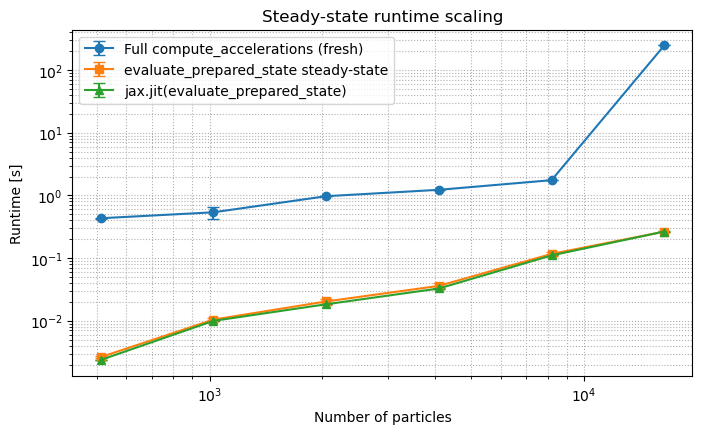

In [9]:
runtime_steady_df = runtime_df.merge(runtime_prepared_df, on="num_particles", suffixes=("", "_prepared"))
runtime_steady_sorted = runtime_steady_df.sort_values("num_particles")

fig, ax = plt.subplots(figsize=(8, 4.5))
ax.errorbar(
    runtime_steady_sorted["num_particles"],
    runtime_steady_sorted["mean_seconds"],
    yerr=runtime_steady_sorted["std_seconds"],
    fmt="o-",
    capsize=4,
    label="Full compute_accelerations (fresh)",
)
ax.errorbar(
    runtime_steady_sorted["num_particles"],
    runtime_steady_sorted["prepared_eval_mean_seconds"],
    yerr=runtime_steady_sorted["prepared_eval_std_seconds"],
    fmt="s-",
    capsize=4,
    label="evaluate_prepared_state steady-state",
)
ax.errorbar(
    runtime_steady_sorted["num_particles"],
    runtime_steady_sorted["prepared_eval_jit_mean_seconds"],
    yerr=runtime_steady_sorted["prepared_eval_jit_std_seconds"],
    fmt="^-",
    capsize=4,
    label="jax.jit(evaluate_prepared_state)",
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Number of particles")
ax.set_ylabel("Runtime [s]")
ax.set_title("Steady-state runtime scaling")
ax.grid(True, which="both", linestyle=":", linewidth=0.8)
ax.legend()
plt.show()


In [10]:
runtime_component_df = profile_prepare_components(
    runtime_particle_counts,
    leaf_size=runtime_leaf_size,
    max_order=runtime_max_order,
    dtype=runtime_working_dtype,
    key=runtime_key,
    fmm_kwargs=runtime_fmm_kwargs,
    runs=max(1, runtime_runs),
    warmup=runtime_warmup,
)
runtime_component_df


,num_particles,tree_build_mean_seconds,upward_mean_seconds,interactions_mean_seconds,downward_mean_seconds,prepare_component_sum_seconds,error
0,512,0.487243,0.000000,0.0,0.0,0.441837,
1,1024,0.378280,0.158519,0.0,0.0,0.536798,
2,2048,0.477031,0.516259,0.0,0.0,0.993290,
3,4096,0.497759,0.740940,0.0,0.0,1.238700,
4,8192,0.484841,1.201354,0.0,0.0,1.686195,
5,16384,1.331036,289.664668,0.0,0.0,290.995704,


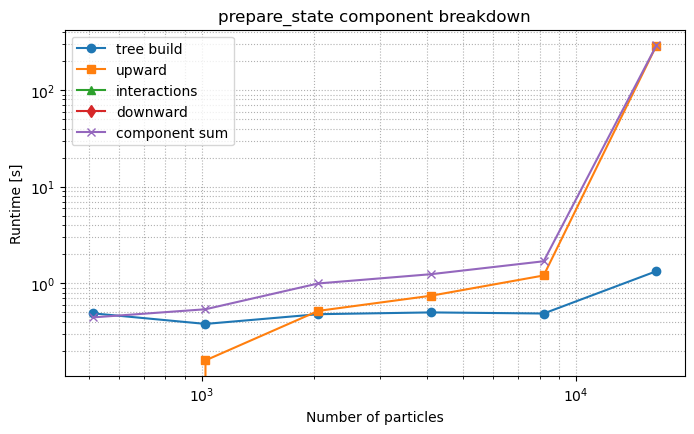

In [11]:
runtime_component_sorted = runtime_component_df.sort_values("num_particles")

fig, ax = plt.subplots(figsize=(8, 4.5))
for col, label, marker in [
    ("tree_build_mean_seconds", "tree build", "o"),
    ("upward_mean_seconds", "upward", "s"),
    ("interactions_mean_seconds", "interactions", "^"),
    ("downward_mean_seconds", "downward", "d"),
    ("prepare_component_sum_seconds", "component sum", "x"),
]:
    ax.plot(
        runtime_component_sorted["num_particles"],
        runtime_component_sorted[col],
        marker=marker,
        label=label,
    )

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Number of particles")
ax.set_ylabel("Runtime [s]")
ax.set_title("prepare_state component breakdown")
ax.grid(True, which="both", linestyle=":", linewidth=0.8)
ax.legend()
plt.show()


### Near-Field Scatter Schedule A/B (Prepared Eval)\n
Compare `evaluate_prepared_state` with precomputed near-field chunk schedules enabled vs disabled.\n

In [ ]:
schedule_ab_num_particles = int(min(16384, max(runtime_particle_counts)))

schedule_ab_runs = max(2, runtime_runs)

schedule_ab_warmup = runtime_warmup



schedule_ab_kwargs = override_fmm_kwargs(
    runtime_fmm_kwargs,
    grouped_interactions=True,
    farfield_mode="class_major",
    nearfield_mode="bucketed",
    nearfield_edge_chunk_size=256,
)



schedule_ab_fmm = FastMultipoleMethod(**schedule_ab_kwargs)

schedule_ab_pos, schedule_ab_mass, _ = bench_utils.generate_random_distribution(

    schedule_ab_num_particles,

    key=runtime_key,

    dtype=runtime_working_dtype,

)



schedule_ab_state = schedule_ab_fmm.prepare_state(

    schedule_ab_pos,

    schedule_ab_mass,

    leaf_size=runtime_leaf_size,

    max_order=runtime_max_order,

)



schedule_ab_state_no_sched = schedule_ab_state._replace(

    nearfield_chunk_sort_indices=None,

    nearfield_chunk_group_ids=None,

    nearfield_chunk_unique_indices=None,

)



schedule_eval_with = bench_utils.time_callable(

    schedule_ab_fmm.evaluate_prepared_state,

    schedule_ab_state,


    warmup=schedule_ab_warmup,

    runs=schedule_ab_runs,

)

schedule_eval_without = bench_utils.time_callable(

    schedule_ab_fmm.evaluate_prepared_state,

    schedule_ab_state_no_sched,


    warmup=schedule_ab_warmup,

    runs=schedule_ab_runs,

)



schedule_ab_df = pd.DataFrame([

    {

        "num_particles": schedule_ab_num_particles,

        "evaluate_mean_with_schedule_s": schedule_eval_with.mean,

        "evaluate_std_with_schedule_s": schedule_eval_with.std,

        "evaluate_mean_without_schedule_s": schedule_eval_without.mean,

        "evaluate_std_without_schedule_s": schedule_eval_without.std,

        "speedup_without_over_with": schedule_eval_without.mean / schedule_eval_with.mean,

    }

])

schedule_ab_df


In [ ]:
fig, ax = plt.subplots(figsize=(6.5, 4.0))\n
labels = ["with schedule", "without schedule"]\n
means = [\n
    float(schedule_ab_df["evaluate_mean_with_schedule_s"].iloc[0]),\n
    float(schedule_ab_df["evaluate_mean_without_schedule_s"].iloc[0]),\n
]\n
stds = [\n
    float(schedule_ab_df["evaluate_std_with_schedule_s"].iloc[0]),\n
    float(schedule_ab_df["evaluate_std_without_schedule_s"].iloc[0]),\n
]\n
ax.bar(labels, means, yerr=stds, capsize=5, color=["#2a9d8f", "#e76f51"])\n
ax.set_ylabel("evaluate_prepared_state runtime [s]")\n
ax.set_title(f"Near-field schedule A/B @ N={schedule_ab_num_particles}")\n
ax.grid(True, axis="y", linestyle=":", linewidth=0.8)\n
plt.show()\n
print("Speedup (without/with):", float(schedule_ab_df["speedup_without_over_with"].iloc[0]))\n

## Sparse vs Grouped Runtime Scaling

Compare end-to-end runtime for the same solidfmm+dehnen setup with
`grouped_interactions=False` (sparse baseline) and `grouped_interactions=True` (grouped path).


In [9]:
runtime_compare_particle_counts = [1024, 4096, 16384, 65536]#, 262144, 524288, 1048576, 2097152]#, 4194304]
runtime_compare_runs = 2
runtime_compare_warmup = 1

runtime_sparse_kwargs = override_fmm_kwargs(runtime_fmm_kwargs, grouped_interactions=False)

runtime_grouped_kwargs = override_fmm_kwargs(runtime_fmm_kwargs, grouped_interactions=True)

runtime_sparse_df = sweep_runtimes(
    runtime_compare_particle_counts,
    leaf_size=runtime_leaf_size,
    max_order=runtime_max_order,
    runs=runtime_compare_runs,
    warmup=runtime_compare_warmup,
    dtype=runtime_working_dtype,
    key=runtime_key,
    fmm_kwargs=runtime_sparse_kwargs,
)

runtime_grouped_df = sweep_runtimes(
    runtime_compare_particle_counts,
    leaf_size=runtime_leaf_size,
    max_order=runtime_max_order,
    runs=runtime_compare_runs,
    warmup=runtime_compare_warmup,
    dtype=runtime_working_dtype,
    key=runtime_key,
    fmm_kwargs=runtime_grouped_kwargs,
)

runtime_compare_df = runtime_sparse_df.merge(
    runtime_grouped_df,
    on="num_particles",
    suffixes=("_sparse", "_grouped"),
)
runtime_compare_df["speedup_full"] = (
    runtime_compare_df["mean_seconds_sparse"]
    / runtime_compare_df["mean_seconds_grouped"]
)
runtime_compare_df


,num_particles,mean_seconds_sparse,std_seconds_sparse,prepare_mean_seconds_sparse,prepare_std_seconds_sparse,evaluate_mean_seconds_sparse,evaluate_std_seconds_sparse,error_sparse,mean_seconds_grouped,std_seconds_grouped,prepare_mean_seconds_grouped,prepare_std_seconds_grouped,evaluate_mean_seconds_grouped,evaluate_std_seconds_grouped,error_grouped,speedup_full
0,1024,0.319833,0.001855,0.341506,0.009729,0.004680,0.000082,,0.334204,0.003277,0.323706,0.000760,0.004486,0.000062,,0.957000
1,4096,0.337405,0.002245,0.314195,0.000815,0.004048,0.000050,,0.332917,0.003513,0.327175,0.001308,0.004535,0.000022,,1.013482
2,16384,0.642664,0.016668,0.614340,0.017183,0.048301,0.000237,,0.509950,0.001588,0.456912,0.002160,0.046103,0.000036,,1.260248
3,65536,9.050016,4.265334,4.228973,0.008085,0.526307,0.002898,,4.345898,0.131962,3.701988,0.004239,0.510707,0.002863,,2.082427


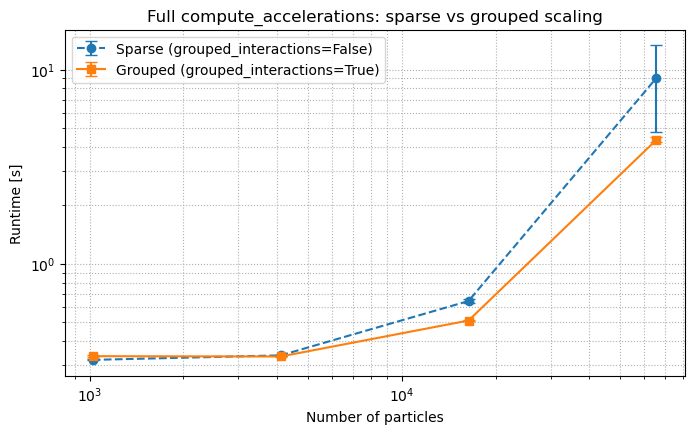

Geometric-mean full-runtime speedup (sparse/grouped): 1.2631018968743306


In [10]:
runtime_compare_sorted = runtime_compare_df.sort_values("num_particles")

fig, ax = plt.subplots(figsize=(8, 4.5))

ax.errorbar(
    runtime_compare_sorted["num_particles"],
    runtime_compare_sorted["mean_seconds_sparse"],
    yerr=runtime_compare_sorted["std_seconds_sparse"],
    fmt="o--",
    capsize=4,
    label="Sparse (grouped_interactions=False)",
)
ax.errorbar(
    runtime_compare_sorted["num_particles"],
    runtime_compare_sorted["mean_seconds_grouped"],
    yerr=runtime_compare_sorted["std_seconds_grouped"],
    fmt="s-",
    capsize=4,
    label="Grouped (grouped_interactions=True)",
)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Number of particles")
ax.set_ylabel("Runtime [s]")
ax.set_title("Full compute_accelerations: sparse vs grouped scaling")
ax.grid(True, which="both", linestyle=":", linewidth=0.8)
ax.legend()
plt.show()

print(
    "Geometric-mean full-runtime speedup (sparse/grouped):",
    float(
        jnp.exp(jnp.mean(jnp.log(runtime_compare_sorted["speedup_full"].to_numpy())))
    ),
)

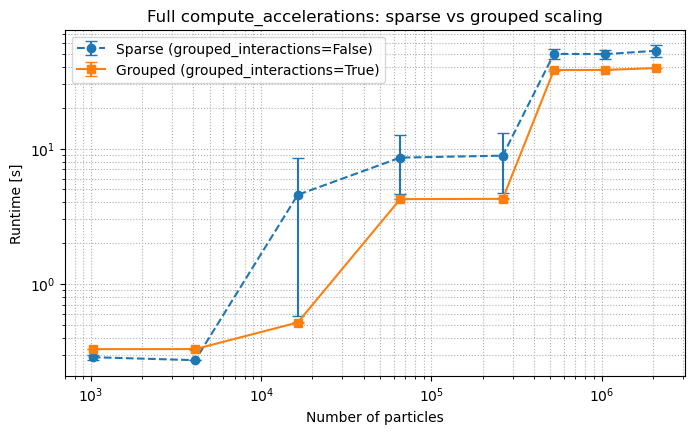

Geometric-mean full-runtime speedup (sparse/grouped): 1.6753454266373007


In [5]:
runtime_compare_sorted = runtime_compare_df.sort_values("num_particles")

fig, ax = plt.subplots(figsize=(8, 4.5))

ax.errorbar(
    runtime_compare_sorted["num_particles"],
    runtime_compare_sorted["mean_seconds_sparse"],
    yerr=runtime_compare_sorted["std_seconds_sparse"],
    fmt="o--",
    capsize=4,
    label="Sparse (grouped_interactions=False)",
)
ax.errorbar(
    runtime_compare_sorted["num_particles"],
    runtime_compare_sorted["mean_seconds_grouped"],
    yerr=runtime_compare_sorted["std_seconds_grouped"],
    fmt="s-",
    capsize=4,
    label="Grouped (grouped_interactions=True)",
)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Number of particles")
ax.set_ylabel("Runtime [s]")
ax.set_title("Full compute_accelerations: sparse vs grouped scaling")
ax.grid(True, which="both", linestyle=":", linewidth=0.8)
ax.legend()
plt.show()

print(
    "Geometric-mean full-runtime speedup (sparse/grouped):",
    float(jnp.exp(jnp.mean(jnp.log(runtime_compare_sorted["speedup_full"].to_numpy())))),
)


## Pair-Grouped vs Class-Major Far-Field Scaling

Both runs below use `grouped_interactions=True` and only differ in
`farfield_mode` (`"pair_grouped"` vs `"class_major"`).
For now the `"class_major"` option is very slow and has some overhead. so we either need to further develop this or kill this option.


In [ ]:
runtime_default_particle_counts = [
    1024,
    4096,
    #16384,
    #65536
]  # [262144]#, 524288, 1048576, 2097152]
runtime_farfield_particle_counts = globals().get("runtime_farfield_particle_counts", runtime_default_particle_counts)
runtime_farfield_runs = globals().get("runtime_compare_runs", 2)
runtime_farfield_warmup = globals().get("runtime_compare_warmup", 1)


runtime_pair_grouped_kwargs = override_fmm_kwargs(
    runtime_fmm_kwargs, grouped_interactions=True, farfield_mode="pair_grouped"
)

runtime_class_major_kwargs = override_fmm_kwargs(
    runtime_fmm_kwargs, grouped_interactions=True, farfield_mode="class_major"
)

runtime_pair_grouped_df = sweep_runtimes(
    runtime_farfield_particle_counts,
    leaf_size=runtime_leaf_size,
    max_order=runtime_max_order,
    runs=runtime_farfield_runs,
    warmup=runtime_farfield_warmup,
    dtype=runtime_working_dtype,
    key=runtime_key,
    fmm_kwargs=runtime_pair_grouped_kwargs,
)

runtime_class_major_df = sweep_runtimes(
    runtime_farfield_particle_counts,
    leaf_size=runtime_leaf_size,
    max_order=runtime_max_order,
    runs=runtime_farfield_runs,
    warmup=runtime_farfield_warmup,
    dtype=runtime_working_dtype,
    key=runtime_key,
    fmm_kwargs=runtime_class_major_kwargs,
)

runtime_farfield_compare_df = runtime_pair_grouped_df.merge(
    runtime_class_major_df,
    on="num_particles",
    suffixes=("_pair_grouped", "_class_major"),
)
runtime_farfield_compare_df["speedup_full"] = (
    runtime_farfield_compare_df["mean_seconds_pair_grouped"]
    / runtime_farfield_compare_df["mean_seconds_class_major"]
)
runtime_farfield_compare_df

,num_particles,mean_seconds_pair_grouped,std_seconds_pair_grouped,prepare_mean_seconds_pair_grouped,prepare_std_seconds_pair_grouped,evaluate_mean_seconds_pair_grouped,evaluate_std_seconds_pair_grouped,error_pair_grouped,mean_seconds_class_major,std_seconds_class_major,prepare_mean_seconds_class_major,prepare_std_seconds_class_major,evaluate_mean_seconds_class_major,evaluate_std_seconds_class_major,error_class_major,speedup_full
0,1024,0.381691,0.021569,0.343805,0.000602,0.004210,0.000079,,0.326640,0.001481,0.318204,0.000447,0.004003,0.000004,,1.168538
1,4096,0.335361,0.001095,0.360341,0.035809,0.004267,0.000075,,0.433277,0.015645,0.319259,0.001976,0.004410,0.000067,,0.774012


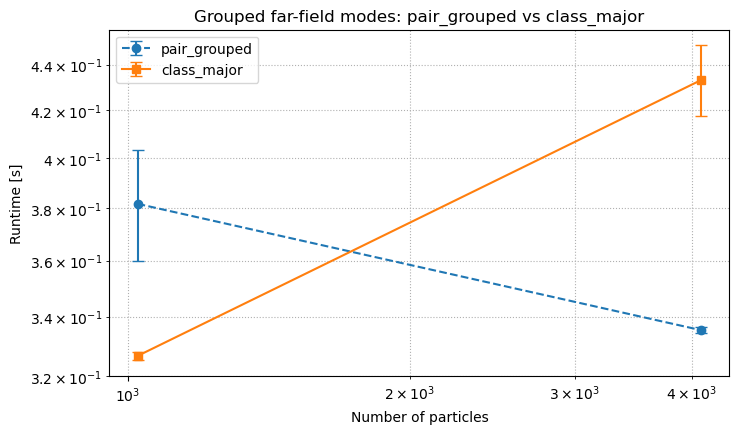

Geometric-mean full-runtime speedup (pair_grouped/class_major): 0.9510318899716439


In [6]:
runtime_farfield_sorted = runtime_farfield_compare_df.sort_values("num_particles")

fig, ax = plt.subplots(figsize=(8, 4.5))

ax.errorbar(
    runtime_farfield_sorted["num_particles"],
    runtime_farfield_sorted["mean_seconds_pair_grouped"],
    yerr=runtime_farfield_sorted["std_seconds_pair_grouped"],
    fmt="o--",
    capsize=4,
    label="pair_grouped",
)
ax.errorbar(
    runtime_farfield_sorted["num_particles"],
    runtime_farfield_sorted["mean_seconds_class_major"],
    yerr=runtime_farfield_sorted["std_seconds_class_major"],
    fmt="s-",
    capsize=4,
    label="class_major",
)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Number of particles")
ax.set_ylabel("Runtime [s]")
ax.set_title("Grouped far-field modes: pair_grouped vs class_major")
ax.grid(True, which="both", linestyle=":", linewidth=0.8)
ax.legend()
plt.show()

print(
    "Geometric-mean full-runtime speedup (pair_grouped/class_major):",
    float(
        jnp.exp(
            jnp.mean(jnp.log(runtime_farfield_sorted["speedup_full"].to_numpy()))
        )
    ),
)


## Near-Field Mode Scaling

Compare near-field execution modes while keeping far-field settings fixed
(`grouped_interactions=True`, `farfield_mode="class_major"`).


In [ ]:
runtime_default_particle_counts = [262144, 524288]#, 1048576, 2097152]
runtime_nearfield_particle_counts = globals().get("runtime_nearfield_particle_counts", runtime_default_particle_counts)
runtime_nearfield_runs = globals().get("runtime_compare_runs", 2)
runtime_nearfield_warmup = globals().get("runtime_compare_warmup", 1)


runtime_nearfield_baseline_kwargs = override_fmm_kwargs(
    runtime_fmm_kwargs,
    grouped_interactions=True,
    farfield_mode="class_major",
    nearfield_mode="baseline",
)

runtime_nearfield_bucketed_kwargs = override_fmm_kwargs(
    runtime_fmm_kwargs,
    grouped_interactions=True,
    farfield_mode="class_major",
    nearfield_mode="bucketed",
    nearfield_edge_chunk_size=256,
)

runtime_nearfield_baseline_df = sweep_runtimes(
    runtime_nearfield_particle_counts,
    leaf_size=runtime_leaf_size,
    max_order=runtime_max_order,
    runs=runtime_nearfield_runs,
    warmup=runtime_nearfield_warmup,
    dtype=runtime_working_dtype,
    key=runtime_key,
    fmm_kwargs=runtime_nearfield_baseline_kwargs,
)

runtime_nearfield_bucketed_df = sweep_runtimes(
    runtime_nearfield_particle_counts,
    leaf_size=runtime_leaf_size,
    max_order=runtime_max_order,
    runs=runtime_nearfield_runs,
    warmup=runtime_nearfield_warmup,
    dtype=runtime_working_dtype,
    key=runtime_key,
    fmm_kwargs=runtime_nearfield_bucketed_kwargs,
)

runtime_nearfield_compare_df = runtime_nearfield_baseline_df.merge(
    runtime_nearfield_bucketed_df,
    on="num_particles",
    suffixes=("_baseline", "_bucketed"),
)
runtime_nearfield_compare_df["speedup_full"] = (
    runtime_nearfield_compare_df["mean_seconds_baseline"]
    / runtime_nearfield_compare_df["mean_seconds_bucketed"]
)
runtime_nearfield_compare_df


In [ ]:
runtime_nearfield_sorted = runtime_nearfield_compare_df.sort_values("num_particles")

fig, ax = plt.subplots(figsize=(8, 4.5))

ax.errorbar(
    runtime_nearfield_sorted["num_particles"],
    runtime_nearfield_sorted["mean_seconds_baseline"],
    yerr=runtime_nearfield_sorted["std_seconds_baseline"],
    fmt="o--",
    capsize=4,
    label="nearfield baseline",
)
ax.errorbar(
    runtime_nearfield_sorted["num_particles"],
    runtime_nearfield_sorted["mean_seconds_bucketed"],
    yerr=runtime_nearfield_sorted["std_seconds_bucketed"],
    fmt="s-",
    capsize=4,
    label="nearfield bucketed",
)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Number of particles")
ax.set_ylabel("Runtime [s]")
ax.set_title("Near-field mode scaling (full compute_accelerations)")
ax.grid(True, which="both", linestyle=":", linewidth=0.8)
ax.legend()
plt.show()

print(
    "Geometric-mean full-runtime speedup (nearfield baseline/bucketed):",
    float(
        jnp.exp(
            jnp.mean(jnp.log(runtime_nearfield_sorted["speedup_full"].to_numpy()))
        )
    ),
)


### Near-Field Split Diagnostics (prepare vs evaluate)

Use the same near-field sweep results to inspect whether gains come from
`prepare_state` or `evaluate_prepared_state`.


In [ ]:
runtime_nearfield_split_df = runtime_nearfield_compare_df.copy()
runtime_nearfield_split_df["speedup_prepare"] = (
    runtime_nearfield_split_df["prepare_mean_seconds_baseline"]
    / runtime_nearfield_split_df["prepare_mean_seconds_bucketed"]
)
runtime_nearfield_split_df["speedup_evaluate"] = (
    runtime_nearfield_split_df["evaluate_mean_seconds_baseline"]
    / runtime_nearfield_split_df["evaluate_mean_seconds_bucketed"]
)
runtime_nearfield_split_df[
    [
        "num_particles",
        "prepare_mean_seconds_baseline",
        "prepare_mean_seconds_bucketed",
        "speedup_prepare",
        "evaluate_mean_seconds_baseline",
        "evaluate_mean_seconds_bucketed",
        "speedup_evaluate",
    ]
]


In [ ]:
runtime_nearfield_split_sorted = runtime_nearfield_split_df.sort_values("num_particles")

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), sharex=True)

axes[0].errorbar(
    runtime_nearfield_split_sorted["num_particles"],
    runtime_nearfield_split_sorted["prepare_mean_seconds_baseline"],
    yerr=runtime_nearfield_split_sorted["prepare_std_seconds_baseline"],
    fmt="o--",
    capsize=4,
    label="prepare baseline",
)
axes[0].errorbar(
    runtime_nearfield_split_sorted["num_particles"],
    runtime_nearfield_split_sorted["prepare_mean_seconds_bucketed"],
    yerr=runtime_nearfield_split_sorted["prepare_std_seconds_bucketed"],
    fmt="s-",
    capsize=4,
    label="prepare bucketed",
)

axes[1].errorbar(
    runtime_nearfield_split_sorted["num_particles"],
    runtime_nearfield_split_sorted["evaluate_mean_seconds_baseline"],
    yerr=runtime_nearfield_split_sorted["evaluate_std_seconds_baseline"],
    fmt="o--",
    capsize=4,
    label="evaluate baseline",
)
axes[1].errorbar(
    runtime_nearfield_split_sorted["num_particles"],
    runtime_nearfield_split_sorted["evaluate_mean_seconds_bucketed"],
    yerr=runtime_nearfield_split_sorted["evaluate_std_seconds_bucketed"],
    fmt="s-",
    capsize=4,
    label="evaluate bucketed",
)

for ax, title in zip(axes, ["prepare_state", "evaluate_prepared_state"]):
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Number of particles")
    ax.set_ylabel("Runtime [s]")
    ax.set_title(title)
    ax.grid(True, which="both", linestyle=":", linewidth=0.8)
    ax.legend()

plt.tight_layout()
plt.show()

print(
    "Geometric-mean speedup prepare (baseline/bucketed):",
    float(jnp.exp(jnp.mean(jnp.log(runtime_nearfield_split_sorted["speedup_prepare"].to_numpy())))),
)
print(
    "Geometric-mean speedup evaluate (baseline/bucketed):",
    float(jnp.exp(jnp.mean(jnp.log(runtime_nearfield_split_sorted["speedup_evaluate"].to_numpy())))),
)


## Expansion-order scaling (accuracy vs multipole order)

For a clean convergence curve, we fix the opening angle θ and sweep the multipole expansion order. This isolates the effect of truncation order on accuracy (at roughly fixed MAC aggressiveness).

Notes:
- Larger orders increase compute cost but should reduce error until other error sources (float precision, tree geometry, MAC) dominate.
- Keeping `order_sweep_particle_count` larger than the θ/order grid can reduce sampling noise in the error curves, but the direct reference is $O(N^2)$ so use with care.

In [5]:
positions_order, masses_order, _ = bench_utils.generate_random_distribution(
    order_sweep_particle_count,
    key=order_diag_key,
    dtype=accuracy_working_dtype,
)

order_sweep_kwargs = override_fmm_kwargs(accuracy_fmm_kwargs, mac_type=order_sweep_mac_type)

order_sweep_df = sweep_accuracy(
    positions_order,
    masses_order,
    thetas=[order_sweep_theta],
    orders=order_sweep_orders,
    leaf_size=order_sweep_leaf_size,
    fmm_kwargs=order_sweep_kwargs,
)
order_sweep_df = order_sweep_df.sort_values("max_order")
order_sweep_df

,theta,max_order,relative_l2_error,relative_max_error
0,0.4,1,5.102115e-04,1.097604e-03
1,0.4,2,9.069028e-05,3.037326e-04
2,0.4,3,1.839668e-05,6.478194e-05
3,0.4,4,4.556598e-06,1.724011e-05
4,0.4,5,1.100707e-06,3.537818e-06
5,0.4,6,3.066950e-07,1.016944e-06
6,0.4,7,9.750637e-08,4.436259e-07
7,0.4,8,3.073884e-08,1.565299e-07


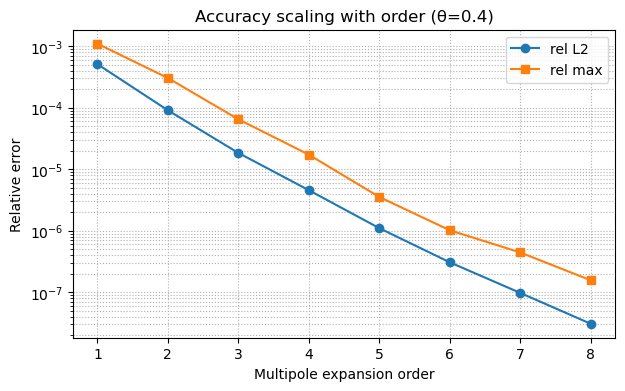

In [6]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.semilogy(
    order_sweep_df["max_order"],
    order_sweep_df["relative_l2_error"],
    marker="o",
    label="rel L2",
)
ax.semilogy(
    order_sweep_df["max_order"],
    order_sweep_df["relative_max_error"],
    marker="s",
    label="rel max",
)
ax.set_xlabel("Multipole expansion order")
ax.set_ylabel("Relative error")
ax.set_title(f"Accuracy scaling with order (θ={order_sweep_theta})")
ax.grid(True, which="both", linestyle=":", linewidth=0.8)
ax.legend()
plt.show()

## MAC sensitivity panel (theta × MAC type)
This panel isolates how much of the global error floor is driven by the MAC criterion at fixed expansion order.


In [11]:
diag_particle_count = 1024
diag_leaf_size = 16
diag_mac_order = 4
diag_thetas = [0.10, 0.18, 0.20, 0.25, 0.30, 0.40]
diag_mac_types = ["bh", "engblom", "dehnen"]
diag_key = jax.random.PRNGKey(42)

positions_diag, masses_diag, _ = bench_utils.generate_random_distribution(
    diag_particle_count,
    key=diag_key,
    dtype=accuracy_working_dtype,
)
reference_diag = direct_accelerations(
    positions_diag,
    masses_diag,
    softening=softening,
)

mac_rows = []
for mac_type in diag_mac_types:
    for theta in diag_thetas:
        kwargs = override_fmm_kwargs(
            accuracy_fmm_kwargs, theta=float(theta), mac_type=mac_type
        )

        fmm = FastMultipoleMethod(**kwargs)
        accelerations = fmm.compute_accelerations(
            positions_diag,
            masses_diag,
            leaf_size=diag_leaf_size,
            max_order=diag_mac_order,
        )

        mac_rows.append(
            {
                "mac_type": mac_type,
                "theta": float(theta),
                "max_order": int(diag_mac_order),
                "relative_l2_error": relative_l2_error(accelerations, reference_diag),
                "relative_max_error": relative_max_error(accelerations, reference_diag),
            }
        )

mac_diag_df = pd.DataFrame(mac_rows).sort_values(["mac_type", "theta"])
mac_diag_df


,mac_type,theta,max_order,relative_l2_error,relative_max_error
0,bh,0.10,4,7.681206e-15,1.303696e-14
1,bh,0.18,4,7.681206e-15,1.303696e-14
2,bh,0.20,4,7.681206e-15,1.303696e-14
3,bh,0.25,4,3.364123e-03,2.008032e-03
4,bh,0.30,4,1.951787e-02,1.217622e-02
5,bh,0.40,4,8.427929e-02,3.514464e-02
12,dehnen,0.10,4,7.693279e-15,1.303696e-14
13,dehnen,0.18,4,7.693279e-15,1.303696e-14
14,dehnen,0.20,4,7.693279e-15,1.303696e-14
15,dehnen,0.25,4,7.693279e-15,1.303696e-14


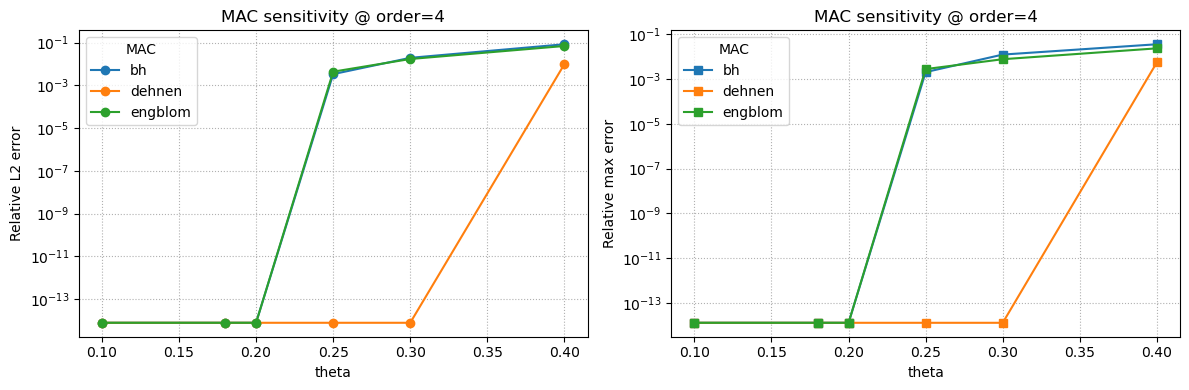

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

for mac_type, group in mac_diag_df.groupby("mac_type"):
    g = group.sort_values("theta")
    axes[0].semilogy(g["theta"], g["relative_l2_error"], marker="o", label=mac_type)
    axes[1].semilogy(g["theta"], g["relative_max_error"], marker="s", label=mac_type)

axes[0].set_xlabel("theta")
axes[0].set_ylabel("Relative L2 error")
axes[0].set_title(f"MAC sensitivity @ order={diag_mac_order}")
axes[0].grid(True, which="both", linestyle=":", linewidth=0.8)
axes[0].legend(title="MAC")

axes[1].set_xlabel("theta")
axes[1].set_ylabel("Relative max error")
axes[1].set_title(f"MAC sensitivity @ order={diag_mac_order}")
axes[1].grid(True, which="both", linestyle=":", linewidth=0.8)
axes[1].legend(title="MAC")

plt.tight_layout()
plt.show()


## Accuracy sweep

Compare FMM outputs against a direct-sum reference for multiple opening angles (θ) and multipole expansion orders. Relative L2 error is reported on a log scale to highlight convergence trends. Values of θ≲0.3 keep the multipole acceptance criterion tight enough for high accuracy; larger θ intentionally trade error for speed.

In [10]:
positions_accuracy, masses_accuracy, _ = bench_utils.generate_random_distribution(
    accuracy_particle_count,
    key=accuracy_key,
    dtype=accuracy_working_dtype,
 )
accuracy_df = sweep_accuracy(
    positions_accuracy,
    masses_accuracy,
    thetas=accuracy_thetas,
    orders=accuracy_orders,
    leaf_size=accuracy_leaf_size,
    fmm_kwargs=accuracy_fmm_kwargs,
 )
accuracy_df

KeyboardInterrupt: 

### Numerical error table

Pivot the sweep results to inspect actual relative errors for each (θ, order) pair.

In [ ]:
accuracy_table = (
    accuracy_df.pivot_table(
        values="relative_l2_error",
        index="max_order",
        columns="theta",
        aggfunc="first",
    )
    .sort_index(axis=0)
    .sort_index(axis=1)
 )
accuracy_table.style.format("{:.2e}").set_caption(
    "Relative L2 error across θ and multipole order"
 )

theta,0.050000,0.100000,0.200000,0.300000,0.400000,0.500000,0.700000,0.900000
max_order,,,,,,,,
1,4.49e-15,4.49e-15,6.17e-03,9.98e-02,2.94e-01,5.03e-01,7.17e-01,8.19e-01
2,4.49e-15,4.49e-15,6.18e-03,1.00e-01,2.95e-01,5.05e-01,7.20e-01,8.25e-01
3,4.49e-15,4.49e-15,6.19e-03,1.00e-01,2.95e-01,5.05e-01,7.20e-01,8.25e-01
4,4.49e-15,4.49e-15,6.19e-03,1.00e-01,2.95e-01,5.05e-01,7.20e-01,8.26e-01


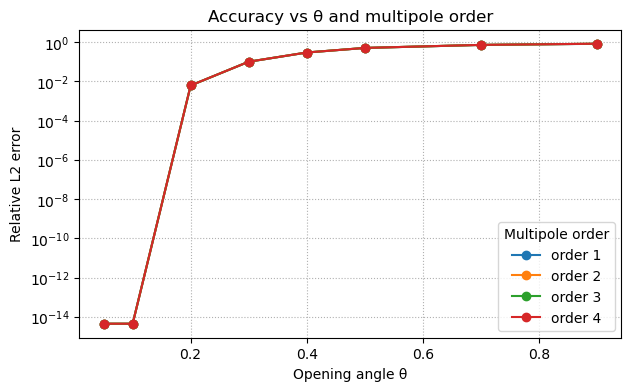

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))
for order in accuracy_orders:
    subset = accuracy_df[accuracy_df["max_order"] == order].sort_values("theta")
    ax.semilogy(
        subset["theta"],
        subset["relative_l2_error"],
        marker="o",
        label=f"order {order}",
    )
ax.set_xlabel("Opening angle θ")
ax.set_ylabel("Relative L2 error")
ax.set_title("Accuracy vs θ and multipole order")
ax.grid(True, which="both", linestyle=":", linewidth=0.8)
ax.legend(title="Multipole order")
plt.show()

## Notes

- Increase `runtime_runs` and `runtime_particle_counts` for more robust profiling once kernels are compiled.
- For accuracy studies on larger systems, subsample particles or use higher-precision reference runs to keep the O(N^2) comparison tractable.
- θ controls how aggressively the dual-tree walk accepts far-field interactions. Keep θ ≤ 0.3 (and ideally ≤ 0.2) for ≲1e-6 relative error; θ ≥ 0.5 trades speed for accuracy and will land in the 1e-2–1e-1 regime even with fourth-order multipoles.
- Feel free to swap in custom presets/parameters via `runtime_fmm_kwargs` and `accuracy_fmm_kwargs` to match production workloads.

## Complex-basis accuracy and rotation timing
Compare complex M2L accuracy vs order for each rotation mode, then time a single M2L at a fixed order.

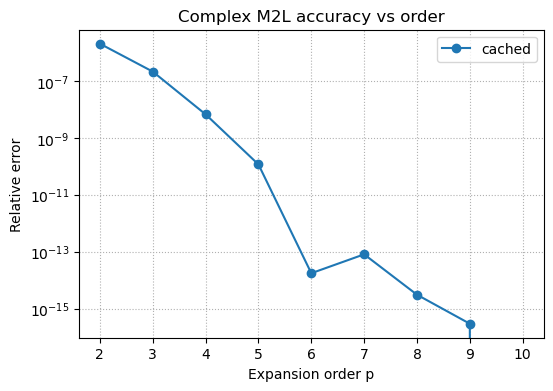

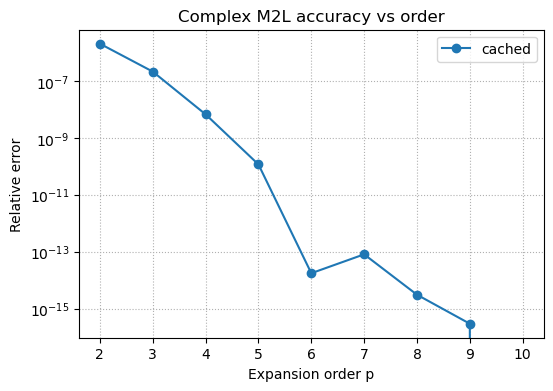

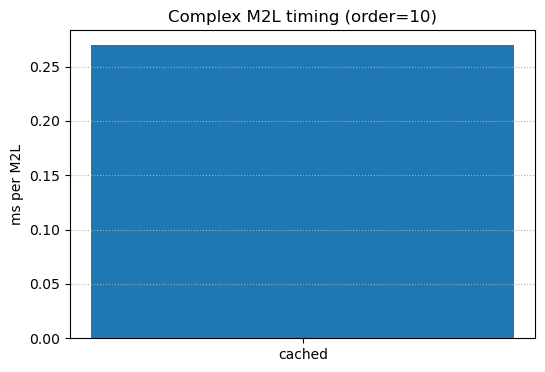

In [ ]:
import time
import importlib
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

import jaccpot.operators.complex_harmonics as complex_harmonics
import jaccpot.operators.complex_ops as complex_ops

importlib.reload(complex_harmonics)
importlib.reload(complex_ops)

complex_R_solidfmm = complex_harmonics.complex_R_solidfmm
complex_dot = complex_ops.complex_dot
m2l_complex_reference = complex_ops.m2l_complex_reference

order_min = 2
order_max = 10
time_order = 10
repeats = 10
conjugate_left = True
# Use solidfmm rotations to match solidfmm operator conventions.
rotations = ["solidfmm"]

dtype = jnp.float64
source_pos = jnp.array([0.2, -0.1, 0.3], dtype=dtype)
multipole_center = jnp.array([0.0, 0.0, 0.0], dtype=dtype)
local_center = jnp.array([3.0, 2.0, 4.0], dtype=dtype)
eval_offset = jnp.array([0.2, -0.1, 0.15], dtype=dtype)

eval_point = local_center + eval_offset
r_direct = jnp.linalg.norm(eval_point - source_pos)
potential_direct = 1.0 / r_direct

delta_p2m = source_pos - multipole_center
delta_m2l = local_center - multipole_center
delta_l2p = local_center - eval_point

orders = list(range(order_min, order_max + 1))
errors_by_rotation = {rot: [] for rot in rotations}

for order in orders:
    multipole = complex_R_solidfmm(delta_p2m, order=order)
    regular = complex_R_solidfmm(delta_l2p, order=order)
    for rot in rotations:
        local = m2l_complex_reference(multipole, delta_m2l, order=order, rotation=rot)
        pot = complex_dot(local, regular, order=order, conjugate_left=conjugate_left)
        pot = jnp.real(pot)
        err = float(jnp.abs(pot - potential_direct) / jnp.abs(potential_direct))
        errors_by_rotation[rot].append(err)

plt.figure(figsize=(6, 4))
for rot in rotations:
    plt.semilogy(orders, errors_by_rotation[rot], marker="o", label=rot)
plt.xlabel("Expansion order p")
plt.ylabel("Relative error")
plt.title("Complex M2L accuracy vs order")
plt.grid(True, which="both", ls=":")
plt.legend()
plt.show()

# Timing comparison (JIT compile + run)
multipole = complex_R_solidfmm(delta_p2m, order=time_order)
regular = complex_R_solidfmm(delta_l2p, order=time_order)
timings_ms = {}
for rot in rotations:
    def _m2l(m, d):
        return m2l_complex_reference(m, d, order=time_order, rotation=rot)
    m2l_jit = jax.jit(_m2l)
    local = m2l_jit(multipole, delta_m2l)
    pot = complex_dot(local, regular, order=time_order, conjugate_left=conjugate_left)
    jnp.asarray(jnp.real(pot)).block_until_ready()
    start = time.perf_counter()
    for _ in range(repeats):
        local = m2l_jit(multipole, delta_m2l)
        pot = complex_dot(local, regular, order=time_order, conjugate_left=conjugate_left)
        jnp.asarray(jnp.real(pot)).block_until_ready()
    elapsed = time.perf_counter() - start
    timings_ms[rot] = elapsed / repeats * 1e3

plt.figure(figsize=(6, 4))
plt.bar(list(timings_ms.keys()), list(timings_ms.values()))
plt.ylabel("ms per M2L")
plt.title(f"Complex M2L timing (order={time_order})")
plt.grid(axis="y", ls=":")
plt.show()

In [ ]:
# Operator micro-benchmarks (complex solidFMM, solidfmm rotations)
import time
import jax
import jax.numpy as jnp
import pandas as pd

from jaccpot.operators.complex_harmonics import p2m_complex_batch, complex_R_solidfmm
from jaccpot.operators.complex_ops import (
    m2m_complex,
    m2l_complex_reference,
    l2l_complex,
    evaluate_local_complex,
 )

bench_order = 6
bench_batch = 2048
bench_repeats = 20
bench_dtype = jnp.float64
key = jax.random.PRNGKey(42)
k1, k2, k3 = jax.random.split(key, 3)

# Random deltas and masses
deltas = jax.random.normal(k1, (bench_batch, 3), dtype=bench_dtype)
masses = jax.random.uniform(k2, (bench_batch,), minval=0.5, maxval=1.5, dtype=bench_dtype)
delta_shift = jax.random.normal(k3, (bench_batch, 3), dtype=bench_dtype)

def _time_ms(fn, *args):
    fn_jit = jax.jit(fn)
    out = fn_jit(*args)
    jax.tree_util.tree_map(lambda x: x.block_until_ready(), out)
    start = time.perf_counter()
    for _ in range(bench_repeats):
        out = fn_jit(*args)
        jax.tree_util.tree_map(lambda x: x.block_until_ready(), out)
    return (time.perf_counter() - start) / bench_repeats * 1e3

# P2M (batched)
p2m_ms = _time_ms(lambda d, m: p2m_complex_batch(d, m, order=bench_order), deltas, masses)
multipoles = p2m_complex_batch(deltas, masses, order=bench_order)

# M2M (batched)
m2m_ms = _time_ms(
    lambda m, d: jax.vmap(lambda mi, di: m2m_complex(mi, di, order=bench_order, rotation="cached"))(m, d),
    multipoles,
    delta_shift,
)
m2m_out = jax.vmap(lambda mi, di: m2m_complex(mi, di, order=bench_order, rotation="cached"))(multipoles, delta_shift)

# M2L (batched)
m2l_ms = _time_ms(
    lambda m, d: jax.vmap(lambda mi, di: m2l_complex_reference(mi, di, order=bench_order, rotation="cached"))(m, d),
    multipoles,
    delta_shift,
)
locals_out = jax.vmap(lambda mi, di: m2l_complex_reference(mi, di, order=bench_order, rotation="cached"))(multipoles, delta_shift)

# L2L (batched)
l2l_ms = _time_ms(
    lambda l, d: jax.vmap(lambda li, di: l2l_complex(li, di, order=bench_order, rotation="cached"))(l, d),
    locals_out,
    delta_shift,
)

# L2P (batched)
l2p_ms = _time_ms(
    lambda l, d: jax.vmap(lambda li, di: evaluate_local_complex(li, di, order=bench_order, conjugate_left=True))(l, d),
    locals_out,
    delta_shift,
)

pd.DataFrame(
    {
        "operator": ["P2M", "M2M", "M2L", "L2L", "L2P"],
        "ms_per_call": [p2m_ms, m2m_ms, m2l_ms, l2l_ms, l2p_ms],
        "batch": [bench_batch] * 5,
        "order": [bench_order] * 5,
    }
 )

,operator,ms_per_call,batch,order
0,P2M,3.710387,2048,6
1,M2M,25.212356,2048,6
2,M2L,29.197633,2048,6
3,L2L,25.186450,2048,6
4,L2P,3.544910,2048,6


## Complex solidFMM operator accuracy (solidfmm rotations)
This section benchmarks accuracy of each complex operator (P2M, M2M, M2L, L2L, L2P) against direct potential or coefficient references, with solidfmm rotations enabled.

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd

from jaccpot.operators.complex_harmonics import complex_R_solidfmm, complex_S_solidfmm, p2m_complex
from jaccpot.operators.complex_ops import (
    complex_dot,
    m2m_complex,
    m2l_complex_reference,
    l2l_complex,
    evaluate_local_complex,
 )

op_orders = list(range(1, 9))
dtype = jnp.float64

source_pos = jnp.array([0.2, -0.1, 0.3], dtype=dtype)
multipole_center = jnp.array([0.0, 0.0, 0.0], dtype=dtype)
parent_center = jnp.array([0.0, 0.0, 0.0], dtype=dtype)
child_center = jnp.array([0.4, -0.2, 0.3], dtype=dtype)
local_center = jnp.array([3.0, 2.0, 4.0], dtype=dtype)
eval_offset = jnp.array([0.2, -0.1, 0.15], dtype=dtype)
eval_offset_child = jnp.array([-0.1, 0.25, 0.05], dtype=dtype)

positions_m2m = jnp.array([[0.3, -0.05, 0.25], [0.1, -0.2, 0.45]], dtype=dtype)
masses_m2m = jnp.array([1.2, 0.7], dtype=dtype)

def p2m_sum(positions, masses, center, *, order):
    deltas = positions - center
    return jnp.sum(
        jax.vmap(lambda d, m: p2m_complex(d, m, order=order))(deltas, masses),
        axis=0,
    )

def multipole_potential(multipole, center, eval_point, *, order):
    delta = eval_point - center
    sing = complex_S_solidfmm(delta, order=order)
    pot = complex_dot(multipole, sing, order=order, conjugate_left=True)
    return jnp.real(pot)

def direct_potential(source, eval_point, mass=1.0):
    r = jnp.linalg.norm(eval_point - source)
    return mass / r

errors = {"P2M": [], "M2M": [], "M2L": [], "L2L": [], "L2P": []}

for order in op_orders:
    # P2M: multipole -> potential vs direct
    multipole = p2m_complex(source_pos - multipole_center, jnp.asarray(1.0, dtype=dtype), order=order)
    eval_point = local_center + eval_offset
    pot_p2m = multipole_potential(multipole, multipole_center, eval_point, order=order)
    pot_direct = direct_potential(source_pos, eval_point)
    errors["P2M"].append(float(jnp.abs(pot_p2m - pot_direct) / jnp.abs(pot_direct)))

    # M2M: compare coefficients (parent direct vs child-translated)
    m_parent = p2m_sum(positions_m2m, masses_m2m, parent_center, order=order)
    m_child = p2m_sum(positions_m2m, masses_m2m, child_center, order=order)
    m_trans = m2m_complex(
        m_child, child_center - parent_center, order=order, rotation="solidfmm"
    )
    errors["M2M"].append(float(jnp.linalg.norm(m_trans - m_parent) / jnp.linalg.norm(m_parent)))

    # M2L: multipole -> local -> potential vs direct
    multipole = p2m_complex(source_pos - multipole_center, jnp.asarray(1.0, dtype=dtype), order=order)
    local = m2l_complex_reference(
        multipole,
        local_center - multipole_center,
        order=order,
        rotation="solidfmm",
    )
    eval_point = local_center + eval_offset
    pot_m2l = evaluate_local_complex(
        local,
        local_center - eval_point,
        order=order,
        conjugate_left=True,
    )
    pot_direct = direct_potential(source_pos, eval_point)
    errors["M2L"].append(float(jnp.abs(pot_m2l - pot_direct) / jnp.abs(pot_direct)))

    # L2L: parent local -> child local -> potential vs direct
    local_child = l2l_complex(
        local, child_center - local_center, order=order, rotation="solidfmm",
    )
    eval_point = child_center + eval_offset_child
    pot_l2l = evaluate_local_complex(
        local_child,
        child_center - eval_point,
        order=order,
        conjugate_left=True,
    )
    pot_direct = direct_potential(source_pos, eval_point)
    errors["L2L"].append(float(jnp.abs(pot_l2l - pot_direct) / jnp.abs(pot_direct)))

    # L2P: evaluate local vs direct (same local as M2L)
    eval_point = local_center + eval_offset_child
    pot_l2p = evaluate_local_complex(
        local,
        local_center - eval_point,
        order=order,
        conjugate_left=True,
    )
    pot_direct = direct_potential(source_pos, eval_point)
    errors["L2P"].append(float(jnp.abs(pot_l2p - pot_direct) / jnp.abs(pot_direct)))

errors_df = pd.DataFrame({"order": op_orders, **errors})
errors_df

,order,P2M,M2M,M2L,L2L,L2P
0,1,2.122826e-03,6.501504e-17,2.468302e-04,0.996167,2.499541e-03
1,2,3.090061e-05,6.567987e-17,2.118073e-06,0.969114,4.076620e-04
2,3,4.242444e-06,6.592160e-17,2.204634e-07,0.992391,1.156763e-05
3,4,5.282580e-07,6.592448e-17,6.894678e-09,0.972729,2.237469e-06
4,5,3.689096e-08,6.592459e-17,1.189108e-10,0.989000,2.608577e-07
5,6,1.695803e-09,6.592459e-17,1.756829e-14,0.975849,1.815797e-09
6,7,2.792099e-11,6.592459e-17,8.139976e-14,0.986182,2.024816e-09
7,8,3.918461e-12,6.584491e-17,3.074451e-15,0.978348,1.734178e-10


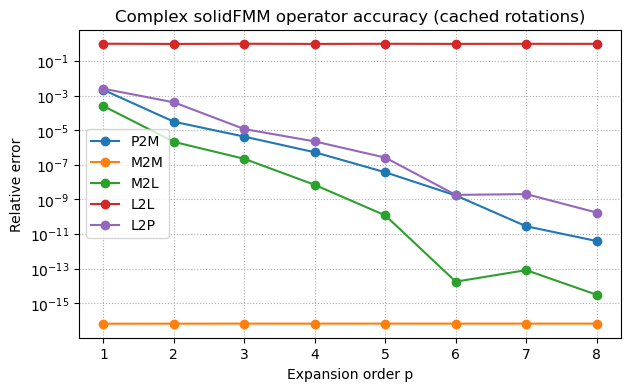

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))
for key in ["P2M", "M2M", "M2L", "L2L", "L2P"]:
    ax.semilogy(errors_df["order"], errors_df[key], marker="o", label=key)
ax.set_xlabel("Expansion order p")
ax.set_ylabel("Relative error")
ax.set_title("Complex solidFMM operator accuracy (solidfmm rotations)")
ax.grid(True, which="both", linestyle=":", linewidth=0.8)
ax.legend()
plt.show()

In [ ]:
# Diagnostics: ensure geometry is in convergence region for L2L/L2P
diag_orders = list(range(1, 9))
dtype = jnp.float64

source_pos = jnp.array([0.25, -0.15, 0.35], dtype=dtype)
multipole_center = jnp.array([0.0, 0.0, 0.0], dtype=dtype)
local_center = jnp.array([4.0, 3.0, 5.0], dtype=dtype)
child_center = local_center + jnp.array([0.3, -0.2, 0.1], dtype=dtype)
eval_offset = jnp.array([0.1, -0.05, 0.08], dtype=dtype)

positions_m2m = jnp.array([[0.3, -0.05, 0.25], [0.1, -0.2, 0.45]], dtype=dtype)
masses_m2m = jnp.array([1.2, 0.7], dtype=dtype)
parent_center = jnp.array([0.0, 0.0, 0.0], dtype=dtype)
child_center_m2m = jnp.array([0.4, -0.2, 0.3], dtype=dtype)

def p2m_sum_complex(positions, masses, center, *, order):
    deltas = positions - center
    return jnp.sum(
        jax.vmap(lambda d, m: p2m_complex(d, m, order=order))(deltas, masses),
        axis=0,
    )

def direct_potential(source, eval_point, mass=1.0):
    r = jnp.linalg.norm(eval_point - source)
    return mass / r

diag_errors = {"M2M": [], "L2L": [], "L2P": []}

for order in diag_orders:
    # M2M coefficient consistency (child -> parent)
    m_parent = p2m_sum_complex(positions_m2m, masses_m2m, parent_center, order=order)
    m_child = p2m_sum_complex(positions_m2m, masses_m2m, child_center_m2m, order=order)
    m_trans = m2m_complex(m_child, child_center_m2m - parent_center, order=order, rotation="solidfmm")
    diag_errors["M2M"].append(float(jnp.linalg.norm(m_trans - m_parent) / jnp.linalg.norm(m_parent)))

    # Build local via M2L (well separated)
    multipole = p2m_complex(source_pos - multipole_center, jnp.asarray(1.0, dtype=dtype), order=order)
    local = m2l_complex_reference(
        multipole,
        local_center - multipole_center,
        order=order,
        rotation="solidfmm",
    )

    # L2L: translate local to a nearby child center and evaluate
    local_child = l2l_complex(
        local,
        child_center - local_center,
        order=order,
        rotation="solidfmm",
    )
    eval_point = child_center + eval_offset
    pot_l2l = evaluate_local_complex(
        local_child,
        child_center - eval_point,
        order=order,
        conjugate_left=True,
    )
    pot_direct = direct_potential(source_pos, eval_point)
    diag_errors["L2L"].append(float(jnp.abs(pot_l2l - pot_direct) / jnp.abs(pot_direct)))

    # L2P: evaluate local near its own center
    eval_point = local_center + eval_offset
    pot_l2p = evaluate_local_complex(
        local,
        local_center - eval_point,
        order=order,
        conjugate_left=True,
    )
    pot_direct = direct_potential(source_pos, eval_point)
    diag_errors["L2P"].append(float(jnp.abs(pot_l2p - pot_direct) / jnp.abs(pot_direct)))

diag_df = pd.DataFrame({"order": diag_orders, **diag_errors})
diag_df

,order,M2M,L2L,L2P
0,1,6.501504e-17,0.043985,5.448736e-04
1,2,6.567987e-17,0.044226,1.580811e-05
2,3,6.592160e-17,0.043937,1.775586e-06
3,4,6.592448e-17,0.043907,7.877016e-08
4,5,6.592459e-17,0.043906,1.643732e-09
5,6,6.592459e-17,0.043906,4.167688e-11
6,7,6.592459e-17,0.043907,5.612339e-12
7,8,6.584491e-17,0.043907,2.724897e-13


### Geometry convergence check
Verify that evaluation points are inside the convergence balls of the local expansions. For a local expansion centered at $c$, the convergence radius is $|c-\text{source}|$; evaluation points should satisfy $|x-c| < |c-\text{source}|$.

In [ ]:
def _add_geom_case(rows, label, source, center, eval_point):
    r_source = float(jnp.linalg.norm(source - center))
    r_eval = float(jnp.linalg.norm(eval_point - center))
    rows.append(
        {
            "case": label,
            "r_source": r_source,
            "r_eval": r_eval,
            "ratio_r_eval_over_r_source": r_eval / r_source if r_source > 0 else float("inf"),
            "inside_convergence": r_eval < r_source,
        }
    )

geom_rows = []

if "source_pos" in globals() and "local_center" in globals() and "eval_offset" in globals():
    _add_geom_case(
        geom_rows,
        "parent_local_eval_offset",
        source_pos,
        local_center,
        local_center + eval_offset,
    )

if "source_pos" in globals() and "child_center" in globals() and "eval_offset" in globals():
    _add_geom_case(
        geom_rows,
        "child_local_eval_offset",
        source_pos,
        child_center,
        child_center + eval_offset,
    )

if "source_pos" in globals() and "child_center" in globals() and "eval_offset_child" in globals():
    _add_geom_case(
        geom_rows,
        "child_local_eval_offset_child",
        source_pos,
        child_center,
        child_center + eval_offset_child,
    )

if "source_pos" in globals() and "local_center" in globals() and "eval_offset_child" in globals():
    _add_geom_case(
        geom_rows,
        "parent_local_eval_offset_child",
        source_pos,
        local_center,
        local_center + eval_offset_child,
    )

if "source_pos" in globals() and "child_local_center" in globals() and "eval_offset" in globals():
    _add_geom_case(
        geom_rows,
        "child_local_center_eval_offset",
        source_pos,
        child_local_center,
        child_local_center + eval_offset,
    )

pd.DataFrame(geom_rows)

,case,r_source,r_eval,ratio_r_eval_over_r_source,inside_convergence
0,parent_local_eval_offset,5.093133,0.269258,0.052867,True
1,child_local_eval_offset,0.223607,0.269258,1.204159,False
2,child_local_eval_offset_child,0.223607,0.273861,1.224745,False
3,parent_local_eval_offset_child,5.093133,0.273861,0.053771,True
4,child_local_center_eval_offset,6.946942,0.269258,0.038759,True


### SolidFMM formula reference check (complex basis)
Compare solidfmm-rotation M2M/L2L against direct formulas using $R_n^m$ (no rotations), and then compare L2P on the translated locals.

In [ ]:
import jax
import jax.numpy as jnp
import pandas as pd
import importlib

from jaccpot.operators.complex_harmonics import complex_R_solidfmm, p2m_complex
import jaccpot.operators.complex_ops as complex_ops
importlib.reload(complex_ops)
from jaccpot.operators.complex_ops import (
    enforce_conjugate_symmetry,
    m2m_complex,
    l2l_complex,
    evaluate_local_complex,
 )
from jaccpot.operators.real_harmonics import sh_index, sh_size

def _rel_err(a, b):
    return float(jnp.linalg.norm(a - b) / jnp.linalg.norm(b))

def m2m_reference_complex(multipole, delta, *, order):
    p = int(order)
    multipole = jnp.asarray(multipole)
    R = complex_R_solidfmm(delta, order=p)
    out = jnp.zeros((sh_size(p),), dtype=multipole.dtype)
    for n in range(p + 1):
        for m in range(-n, n + 1):
            acc = 0.0 + 0.0j
            for k in range(p + 1):
                if n - k < 0:
                    continue
                for l in range(-k, k + 1):
                    q = n - k
                    t = m - l
                    if abs(t) > q:
                        continue
                    acc = acc + multipole[sh_index(k, l)] * R[sh_index(q, t)]
            out = out.at[sh_index(n, m)].set(acc)
    return out

def l2l_reference_complex(local, delta, *, order):
    p = int(order)
    local = jnp.asarray(local)
    R = complex_R_solidfmm(delta, order=p)
    out = jnp.zeros((sh_size(p),), dtype=local.dtype)
    for n in range(p + 1):
        for m in range(-n, n + 1):
            acc = 0.0 + 0.0j
            for k in range(n, p + 1):
                for l in range(-k, k + 1):
                    q = k - n
                    t = l - m
                    if abs(t) > q:
                        continue
                    acc = acc + local[sh_index(k, l)] * jnp.conjugate(R[sh_index(q, t)])
            out = out.at[sh_index(n, m)].set(acc)
    return out

orders_ref = list(range(1, 8))
dtype = jnp.float64
delta_ref = jnp.array([0.35, -0.25, 0.45], dtype=dtype)
eval_offset = jnp.array([0.02, -0.01, 0.03], dtype=dtype)

# Use P2M to generate physical multipoles and locals (conjugate-symmetric by construction)
positions = jnp.array([[0.3, -0.05, 0.25], [0.1, -0.2, 0.45]], dtype=dtype)
masses = jnp.array([1.2, 0.7], dtype=dtype)

def p2m_sum(positions, masses, center, *, order):
    deltas = positions - center
    return jnp.sum(
        jax.vmap(lambda d, m: p2m_complex(d, m, order=order))(deltas, masses),
        axis=0,
    )


rows = []
for order in orders_ref:
    multipole = p2m_sum(positions, masses, jnp.zeros(3, dtype=dtype), order=order)
    local = p2m_sum(positions, masses, jnp.zeros(3, dtype=dtype), order=order)  # for L2L, just use same as multipole

    m2m_ref = m2m_reference_complex(multipole, delta_ref, order=order)
    l2l_ref = l2l_reference_complex(local, delta_ref, order=order)

    m2m_cached = m2m_complex(multipole, delta_ref, order=order, rotation="cached")
    m2m_wigner = m2m_complex(multipole, delta_ref, order=order, rotation="wigner")
    m2m_solidfmm = m2m_complex(multipole, delta_ref, order=order, rotation="solidfmm")

    l2l_cached = l2l_complex(local, delta_ref, order=order, rotation="cached")
    l2l_wigner = l2l_complex(local, delta_ref, order=order, rotation="wigner")
    l2l_solidfmm = l2l_complex(local, delta_ref, order=order, rotation="solidfmm")

    pot_cached = evaluate_local_complex(l2l_cached, eval_offset, order=order, conjugate_left=True)
    pot_wigner = evaluate_local_complex(l2l_wigner, eval_offset, order=order, conjugate_left=True)
    pot_solidfmm = evaluate_local_complex(l2l_solidfmm, eval_offset, order=order, conjugate_left=True)
    pot_ref = evaluate_local_complex(l2l_ref, eval_offset, order=order, conjugate_left=True)

    rows.append(
        {
            "order": order,
            "m2m_cached_rel_err": _rel_err(m2m_cached, m2m_ref),
            "m2m_wigner_rel_err": _rel_err(m2m_wigner, m2m_ref),
            "m2m_solidfmm_rel_err": _rel_err(m2m_solidfmm, m2m_ref),
            "l2l_cached_rel_err": _rel_err(l2l_cached, l2l_ref),
            "l2l_wigner_rel_err": _rel_err(l2l_wigner, l2l_ref),
            "l2l_solidfmm_rel_err": _rel_err(l2l_solidfmm, l2l_ref),
            "l2p_cached_rel_err": float(jnp.abs(pot_cached - pot_ref) / jnp.maximum(jnp.abs(pot_ref), 1e-30)),
            "l2p_wigner_rel_err": float(jnp.abs(pot_wigner - pot_ref) / jnp.maximum(jnp.abs(pot_ref), 1e-30)),
            "l2p_solidfmm_rel_err": float(jnp.abs(pot_solidfmm - pot_ref) / jnp.maximum(jnp.abs(pot_ref), 1e-30)),
        },
    )

pd.DataFrame(rows)

,order,m2m_cached_rel_err,m2m_wigner_rel_err,m2m_solidfmm_rel_err,l2l_cached_rel_err,l2l_wigner_rel_err,l2l_solidfmm_rel_err,l2p_cached_rel_err,l2p_wigner_rel_err,l2p_solidfmm_rel_err
0,1,0.737822,0.800883,1.833720e-16,0.034210,0.012251,4.977179e-17,0.035423,0.012685,0.000000e+00
1,2,0.777687,0.833132,2.046123e-16,0.043705,0.021300,1.866516e-16,0.041526,0.016350,1.912876e-16
2,3,0.780003,0.834694,2.055369e-16,0.044432,0.022130,1.918103e-16,0.041776,0.016547,3.824995e-16
3,4,0.780113,0.834767,2.056069e-16,0.044451,0.022156,5.212927e-17,0.041780,0.016550,0.000000e+00
4,5,0.780117,0.834770,2.056137e-16,0.044451,0.022157,7.715290e-17,0.041780,0.016550,0.000000e+00
5,6,0.780117,0.834770,2.056138e-16,0.044451,0.022157,3.894989e-16,0.041780,0.016550,3.824987e-16
6,7,0.780117,0.834770,2.056138e-16,0.044451,0.022157,2.091815e-16,0.041780,0.016550,1.912493e-16


In [ ]:
# Solidfmm M2M check with conjugate-symmetric multipoles (P2M).
import jax
import jax.numpy as jnp
import pandas as pd

from jaccpot.operators.complex_harmonics import p2m_complex
from jaccpot.operators.complex_ops import m2m_complex

orders_sym = list(range(1, 8))
dtype = jnp.float64
parent_center = jnp.array([0.0, 0.0, 0.0], dtype=dtype)
child_center = jnp.array([0.4, -0.2, 0.3], dtype=dtype)
positions = jnp.array([[0.3, -0.05, 0.25], [0.1, -0.2, 0.45]], dtype=dtype)
masses = jnp.array([1.2, 0.7], dtype=dtype)

def p2m_sum_sym(positions, masses, center, *, order):
    deltas = positions - center
    return jnp.sum(
        jax.vmap(lambda d, m: p2m_complex(d, m, order=order))(deltas, masses),
        axis=0,
    )

rows = []
delta_m2m = child_center - parent_center
for order in orders_sym:
    m_parent = p2m_sum_sym(positions, masses, parent_center, order=order)
    m_child = p2m_sum_sym(positions, masses, child_center, order=order)
    m_trans = m2m_complex(
        m_child,
        delta_m2m,
        order=order,
        rotation="solidfmm",
    )
    m_trans_flip = m2m_complex(
        m_child,
        -delta_m2m,
        order=order,
        rotation="solidfmm",
    )
    err = float(jnp.linalg.norm(m_trans - m_parent) / jnp.linalg.norm(m_parent))
    err_flip = float(
        jnp.linalg.norm(m_trans_flip - m_parent) / jnp.linalg.norm(m_parent)
    )
    rows.append(
        {
            "order": order,
            "m2m_solidfmm_rel_err": err,
            "m2m_solidfmm_rel_err_flip": err_flip,
        }
    )

pd.DataFrame(rows)

,order,m2m_solidfmm_rel_err,m2m_solidfmm_rel_err_flip
0,1,6.501504e-17,0.817961
1,2,6.567987e-17,0.826626
2,3,6.592160e-17,0.827141
3,4,6.592448e-17,0.827155
4,5,6.592459e-17,0.827155
5,6,6.592459e-17,0.827155
6,7,6.592459e-17,0.827155


In [ ]:
# Multipole rotation invariance check (potential should be rotation-invariant).
import jax
import jax.numpy as jnp
import pandas as pd

from jaccpot.operators.complex_harmonics import complex_S_solidfmm
from jaccpot.operators.complex_ops import (
    complex_dot,
    rotate_complex_multipole_to_z_cached,
    rotate_complex_multipole_to_z_solidfmm,
    rotate_complex_multipole_to_z_wigner,
 )
from jaccpot.operators.real_harmonics import sh_size

orders_rot = list(range(1, 8))
dtype = jnp.float64
delta_rot = jnp.array([0.35, -0.25, 0.45], dtype=dtype)
r_rot = jnp.linalg.norm(delta_rot)
delta_z = jnp.array([0.0, 0.0, r_rot], dtype=dtype)

rows_rot = []
for order in orders_rot:
    key = jax.random.PRNGKey(100 + order)
    multipole = (
        jax.random.normal(key, (sh_size(order),), dtype=dtype)
        + 1j * jax.random.normal(key, (sh_size(order),), dtype=dtype)
    )
    sing_orig = complex_S_solidfmm(delta_rot, order=order)
    sing_z = complex_S_solidfmm(delta_z, order=order)
    pot_orig = jnp.real(complex_dot(multipole, sing_orig, order=order, conjugate_left=True))

    mp_cached = rotate_complex_multipole_to_z_cached(multipole, delta_rot, order=order)
    mp_wigner = rotate_complex_multipole_to_z_wigner(multipole, delta_rot, order=order)
    mp_solidfmm = rotate_complex_multipole_to_z_solidfmm(multipole, delta_rot, order=order)

    pot_cached = jnp.real(complex_dot(mp_cached, sing_z, order=order, conjugate_left=True))
    pot_wigner = jnp.real(complex_dot(mp_wigner, sing_z, order=order, conjugate_left=True))
    pot_solidfmm = jnp.real(complex_dot(mp_solidfmm, sing_z, order=order, conjugate_left=True))

    denom = jnp.maximum(jnp.abs(pot_orig), 1e-30)
    rows_rot.append(
        {
            "order": order,
            "cached_rel_err": float(jnp.abs(pot_cached - pot_orig) / denom),
            "wigner_rel_err": float(jnp.abs(pot_wigner - pot_orig) / denom),
            "solidfmm_rel_err": float(jnp.abs(pot_solidfmm - pot_orig) / denom),
        }
    )

pd.DataFrame(rows_rot)

,order,cached_rel_err,wigner_rel_err,solidfmm_rel_err
0,1,0.736059,0.569595,1.277644
1,2,0.543699,0.446619,2.612488
2,3,0.671185,1.479527,6.104541
3,4,3.112633,1.823976,9.241313
4,5,2.775162,0.656145,17.605694
5,6,1.206246,0.712950,26.393418
6,7,4.457295,0.770768,44.936718


In [ ]:
# Local rotation invariance check (potential should be rotation-invariant).
import jax
import jax.numpy as jnp
import pandas as pd

from jaccpot.operators.complex_harmonics import complex_R_solidfmm
from jaccpot.operators.complex_ops import (
    complex_dot,
    rotate_complex_local_to_z_cached,
    rotate_complex_local_to_z_solidfmm,
    rotate_complex_local_to_z_wigner,
 )
from jaccpot.operators.real_harmonics import sh_size

orders_loc = list(range(1, 8))
dtype = jnp.float64
delta_loc = jnp.array([0.35, -0.25, 0.45], dtype=dtype)
r_loc = jnp.linalg.norm(delta_loc)
delta_z_loc = jnp.array([0.0, 0.0, r_loc], dtype=dtype)

rows_loc = []
for order in orders_loc:
    key = jax.random.PRNGKey(200 + order)
    local = (
        jax.random.normal(key, (sh_size(order),), dtype=dtype)
        + 1j * jax.random.normal(key, (sh_size(order),), dtype=dtype)
    )
    reg_orig = complex_R_solidfmm(delta_loc, order=order)
    reg_z = complex_R_solidfmm(delta_z_loc, order=order)
    pot_orig = jnp.real(complex_dot(local, reg_orig, order=order, conjugate_left=True))

    loc_cached = rotate_complex_local_to_z_cached(local, delta_loc, order=order)
    loc_wigner = rotate_complex_local_to_z_wigner(local, delta_loc, order=order)
    loc_solidfmm = rotate_complex_local_to_z_solidfmm(local, delta_loc, order=order)

    pot_cached = jnp.real(complex_dot(loc_cached, reg_z, order=order, conjugate_left=True))
    pot_wigner = jnp.real(complex_dot(loc_wigner, reg_z, order=order, conjugate_left=True))
    pot_solidfmm = jnp.real(complex_dot(loc_solidfmm, reg_z, order=order, conjugate_left=True))

    denom = jnp.maximum(jnp.abs(pot_orig), 1e-30)
    rows_loc.append(
        {
            "order": order,
            "cached_rel_err": float(jnp.abs(pot_cached - pot_orig) / denom),
            "wigner_rel_err": float(jnp.abs(pot_wigner - pot_orig) / denom),
            "solidfmm_rel_err": float(jnp.abs(pot_solidfmm - pot_orig) / denom),
        }
    )

pd.DataFrame(rows_loc)

,order,cached_rel_err,wigner_rel_err,solidfmm_rel_err
0,1,0.523690,0.662759,0.000000e+00
1,2,0.594101,0.550489,1.220866e-16
2,3,317.877155,204.392571,2.044381e-13
3,4,0.124986,0.036564,2.040296e-16
4,5,0.109744,0.398004,3.360924e-16
5,6,0.264799,0.460519,3.346286e-16
6,7,0.670896,1.268442,5.201094e-16
